In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
from pandas.io.json import json_normalize

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [9]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [10]:
start_dt = '2021-07-20'
end_dt = '2021-07-21'

which campaigns went dark between 9:20 and 11am on 7/21?

In [117]:
df = bigquery_client.query(f"""
select
    case when r.ssb_buyer_id = 3549 then 'DT' else 'RON' end as buyer
    , date
    , extract(dayofweek from timestamp) as dow
    , extract(hour from timestamp) as hour
    , extract(minute from timestamp) as minute
    , c.name as campaign_name
    , r.ssb_campaign_uuid
    , sp.name as app_name
    , count(case when event_type = 'clear' then 1 else NULL end) as impressions
    , count(case when event_type = 'click' then 1 else NULL end) as clicks
    , count(case when event_type = 'install' then 1 else NULL end) as installs
    , sum(revenue) as spend
    , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)/1000 as bid
from stats.rows1 r
join metadata.campaigns c 
    on r.ssb_campaign_uuid = c.uuid
left join metadata.apps sp 
    on r.sponsored_app_id = sp.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
group by 1,2,3,4,5,6,7,8
""").to_dataframe()
df['date'] = df['date'].astype('datetime64')
df['spend'] = df['spend'].astype('float')
df['cost'] = df['cost'].astype('float')
df

buyer       date  dow  hour  minute  \
0         RON 2021-07-20    3     3      32   
1         RON 2021-07-20    3     3      38   
2         RON 2021-07-20    3     3      45   
3         RON 2021-07-20    3     3      43   
4         RON 2021-07-20    3     3      50   
...       ...        ...  ...   ...     ...   
1106916   RON 2021-07-21    4    13      25   
1106917   RON 2021-07-21    4    16      26   
1106918   RON 2021-07-21    4    16      17   
1106919   RON 2021-07-21    4    16      34   
1106920   RON 2021-07-21    4    16      34   

                                      campaign_name  \
0        MercadoLibre_Winclap_Appreciate_Android_BR   
1        MercadoLibre_Winclap_Appreciate_Android_CL   
2                                UZ Beeline Fantasy   
3                                UZ Beeline Fantasy   
4                               Sleep Well!!_US_iOS   
...                                             ...   
1106916       161402 1024x768 Refresh DE IOS MW 10%   
1106917        Unacademy_Android_IN_July21_CasualWL   
1106918                  140413 1024x768 US MW -40%   
1106919                  147402 1024x768 CH MW -20%   
1106920                           Castle - iOS - UK   

                        ssb_campaign_uuid  \
0        16dd6a2d270567b7135d8b38c8ea5c14   
1        4fd8397fa82689d0b6d0e6485dff3fcc   
2        2b65203d28e4f08a9ab24bb68c187c09   
3        2b65203d28e4f08a9ab24bb68c187c09   
4        35a8d32fe0e2b24bdd0d2fb62cb17af4   
...                                   ...   
1106916  d16a4fa6a5bc5ec8e5e39333a6c21b73   
1106917  580854844dc00aea9fc01aa79b508471   
1106918  e5d2a017422770c9c607fbc356be3eb3   
1106919  a45453206a1c9e884b454bf071f7fd83   
1106920  f86c3b33c09264d22bb379991a53df86   

                                     app_name  impressions  clicks  installs  \
0        Mercado Libre: compra fácil y rápido          635       2         0   
1        Mercado Libre: compra fácil y rápido          629       2         0   
2                                        None           65       2         0   
3                                        None           76       5         0   
4                                Sleep Well!!          121       1         0   
...                                       ...          ...     ...       ...   
1106916                                  None            1       0         0   
1106917                Unacademy Learning App            1       0         0   
1106918                                  None            0       0         0   
1106919                                  None            1       0         0   
1106920           Castle Solitaire: Card Game            1       0         0   

           spend      cost       bid  
0        0.00000  0.076732  0.082804  
1        0.00000  0.047662  0.050491  
2        0.00000  0.038844  0.040394  
3        0.00000  0.043200  0.045755  
4        0.00000  0.016973  0.017263  
...          ...       ...       ...  
1106916  0.00000  0.001260  0.001801  
1106917  0.00000  0.000084  0.000086  
1106918  0.00165  0.000000  0.000000  
1106919  0.00000  0.001010  0.001234  
1106920  0.00000  0.000220  0.000220  

[1106921 rows x 14 columns]

<AxesSubplot:xlabel='hour,minute'>

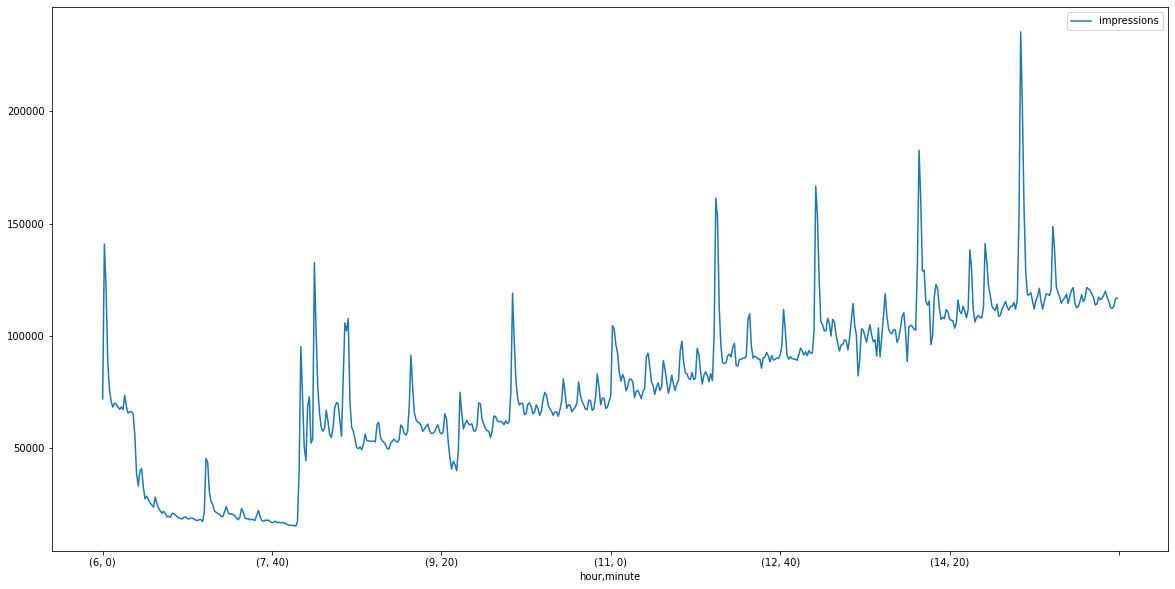

In [122]:
filters = (df.date == '2021-07-21') & (df.hour >= 6) & (df.hour <= 15)
df[filters].pivot_table(values = 'impressions', index = ['hour','minute'], aggfunc = np.sum).plot(figsize = (20,10))

<AxesSubplot:xlabel='hour,minute'>

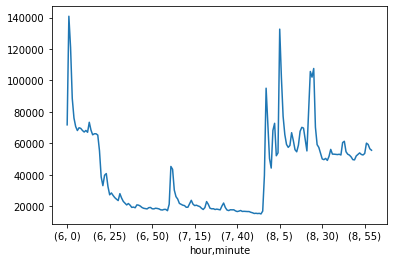

In [119]:
filters = (df.date == '2021-07-21') & (df.hour>=6) & (df.hour < 9)
df[filters].groupby(['hour','minute'])['impressions'].sum().plot()

In [123]:
filters = ((df.hour == 6) & (df.minute > 20)) | ((df.hour == 7) & (df.minute < 55))
pivot = df[filters].pivot_table(values = 'impressions', index = ['campaign_name','ssb_campaign_uuid','app_name'], columns = 'date', aggfunc = np.sum)
pivot['diff'] = pivot['2021-07-21']/pivot['2021-07-20']-1

dropped_campaigns = pivot[((pivot[datetime.datetime(2021,7,21)].isna()) | (pivot['diff'] < -.9)) & (pivot[datetime.datetime(2021,7,20)]>100)].sort_values(pivot.columns[0], ascending = False)
dropped_id_list = dropped_campaigns.index.get_level_values(1).tolist()
dropped_campaigns.to_csv('~/Downloads/7.21_outage.csv')
dropped_campaigns

date                                                                                                                                   2021-07-20 00:00:00  \
campaign_name                                      ssb_campaign_uuid                app_name                                                                 
Android-Twitter-Twitter-ID-4                       e8fd14220c0331282ea593f073fe10c7 Twitter                                                       228699.0   
Android-Twitter-Twitter-PH-4                       880dcc26340e247dcfbea4bceea58fe5 Twitter                                                       155196.0   
Android-Twitter-Twitter-FR-4                       c6583d198719c3adb7a5648ed72ce27a Twitter                                                       153116.0   
Android-Twitter-Twitter-UK-4                       65b37ef0810672f4f347d5326d26bb32 Twitter                                                       136937.0   
Android-Twitter-Twitter-IT-4                       5e3c12bd35bb9872d01487e8951075ee Twitter                                                       136537.0   
...                                                                                                                                                    ...   
PlaySimple-Word Trip-US-VZW-T1                     fbc615e1cde9d19c9e8b242169446835 Word Trip                                                        266.0   
Android-Papaya Games-Solitaire Cash-4              8b1493dacec7f61aa46ca190b0973853 solitaire cash                                                   239.0   
DT - SingleTap - Pandora - Pandora iOS - US - C... 03f0cd8dc504ff18466e68d45cf25757 Pandora: Music & Podcasts                                        238.0   
DT - SingleTap - Pandora - Pandora iOS - US - I... bda2009e269592a190a3b7862b58e2fb Pandora: Music & Podcasts                                        217.0   
Particle Media - News Break - US - USCC PR         8e6627e38eabb03d429be94f92c185f5 NewsBreak: Local News that Connects the Community                216.0   

date                                                                                                                                   2021-07-21 00:00:00  \
campaign_name                                      ssb_campaign_uuid                app_name                                                                 
Android-Twitter-Twitter-ID-4                       e8fd14220c0331282ea593f073fe10c7 Twitter                                                            NaN   
Android-Twitter-Twitter-PH-4                       880dcc26340e247dcfbea4bceea58fe5 Twitter                                                            NaN   
Android-Twitter-Twitter-FR-4                       c6583d198719c3adb7a5648ed72ce27a Twitter                                                          118.0   
Android-Twitter-Twitter-UK-4                       65b37ef0810672f4f347d5326d26bb32 Twitter                                                            NaN   
Android-Twitter-Twitter-IT-4                       5e3c12bd35bb9872d01487e8951075ee Twitter                                                            NaN   
...                                                                                                                                                    ...   
PlaySimple-Word Trip-US-VZW-T1                     fbc615e1cde9d19c9e8b242169446835 Word Trip                                                          NaN   
Android-Papaya Games-Solitaire Cash-4              8b1493dacec7f61aa46ca190b0973853 solitaire cash                                                     9.0   
DT - SingleTap - Pandora - Pandora iOS - US - C... 03f0cd8dc504ff18466e68d45cf25757 Pandora: Music & Podcasts                                          NaN   
DT - SingleTap - Pandora - Pandora iOS - US - I... bda2009e269592a190a3b7862b58e2fb Pandora: Music & Podcasts                                          NaN   
Particle Media - News Break - US - USCC PR       

In [124]:
filters = (df.date == '2021-07-21') & (((df.hour==6) & (df.minute > 20)) | (df.hour == 7)) & (df.ssb_campaign_uuid.isin(dropped_campaigns))
pivot = df[filters].groupby(['ssb_campaign_uuid'])['impressions'].sum().to_frame()
top_bug_spenders = pivot.sort_values('impressions', ascending = False).head(30).index.tolist()

In [125]:
c = '0282f78e216dfd3118d71a5fe5ff49bf'
filters = (df.date == '2021-07-21') & (df.hour>=6) & (df.hour < 9) & (df.ssb_campaign_uuid == c)
pivot = df[filters].pivot_table(values = 'impressions', index = ['hour','minute'], aggfunc = np.sum)
pivot[pivot.index.get_level_values(0) == 7]#.plot(figsize = (10,5), title = c)

impressions
hour minute             
7    55               31
     56              763
     57             1296
     58             1842
     59             1585